In [1]:
import sys
import os
myDir = os.getcwd()
parentDir = os.path.abspath(os.path.join(myDir, os.pardir))
sys.path.append(parentDir)

from pathlib import Path
path = Path(parentDir)
a=str(path.parent.absolute())

sys.path.append(a)

In [2]:
from MetaX.utils.taxaFuncAnalyzer import TaxaFuncAnalyzer
from MetaX.utils.taxaFuncPloter.basic_plot import BasicPlot


In [3]:
df_path = 'example_data/SW_TaxaFunc.tsv'
meta_path = 'example_data/SW_meta.tsv'
sw = TaxaFuncAnalyzer(df_path, meta_path)

original df shape: (3999, 229)
after remove all zero row: (3999, 229)


In [4]:
sw.set_func('Description')
sw.set_multi_tables(level='s')

sw.set_group('Person')

batch_list is not set, Batch effect removal did not perform.
transform_method is not set, data transform did not perform.
normalize_method is not set, data normalization did not perform.
Original data shape: (3999, 229)
Starting to set Function table...
Function number: 830
Starting to set Taxa table...
Taxa number: 340
Taxa-Function number: 1272
group is set to Person
 {'V1', 'V5', 'V4', 'V2', 'V3'}


In [6]:
df = sw.get_intensity_matrix(func_name='ROK family')
# df = sw.get_intensity_matrix(taxon_name="d__Bacteria|p__Actinobacteriota|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella sp900762015")
display(df.head())

,V1_01,V1_02,V1_03,V1_04,V1_05,V1_06,V1_07,V1_08,V1_09,V1_10,...,V5_29,V5_30,V5_31,V5_32,V5_33,V5_34,V5_35,V5_36,V5_37,V5_38
Taxon,,,,,,,,,,,,,,,,,,,,,
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum,395691,504180,780224,0,680716,0,0,504892,286673,270460,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Bacteroidota|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Prevotella|s__Prevotella copri_A,0,107983,360580,0,0,0,0,0,0,261555,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Firmicutes_A|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Agathobacter|s__Agathobacter rectalis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,546449,0,0
d__Bacteria|p__Firmicutes_A|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Roseburia|s__Roseburia hominis,246602,575718,595770,763091,818482,216592,890081,577186,413871,702795,...,676712,1622676,2097777,549815,2620374,2961584,3153684,4050247,2940956,2875664


In [14]:
df_anova = sw.get_stats_anova()

ANOVA test for Taxon in ['V1', 'V2', 'V3', 'V4', 'V5']


100%|██████████| 1272/1272 [00:03<00:00, 388.45it/s]


In [32]:
display(df_anova.head())

P-value  \
Taxon                                              Description                                                        
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Belongs to the transketolase family                 1.136078e-06   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... D-xylulose 5-phosphate/D-fructose 6-phosphate p...  6.058243e-05   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Binds to Cpn60 in the presence of Mg-ATP and su...  7.744767e-04   
                                                   Binds to the 23S rRNA                               1.750501e-36   
                                                   DivIVA protein                                      5.489923e-41   

                                                                                                       f-statistic  \
Taxon                                              Description                                                       
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Belongs to the transketolase family                    9.011100   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... D-xylulose 5-phosphate/D-fructose 6-phosphate p...     6.539947   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Binds to Cpn60 in the presence of Mg-ATP and su...     4.983460   
                                                   Binds to the 23S rRNA                                 71.420160   
                                                   DivIVA protein                                        85.473182   

                                                                                                       V1_01  \
Taxon                                              Description                                                 
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Belongs to the transketolase family                     0   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... D-xylulose 5-phosphate/D-fructose 6-phosphate p...      0   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Binds to Cpn60 in the presence of Mg-ATP and su...      0   
                                                   Binds to the 23S rRNA                                   0   
                                                   DivIVA protein                                          0   

                                                                                                       V1_02  \
Taxon                                              Description                                                 
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Belongs to the transketolase family                     0   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... D-xylulose 5-phosphate/D-fructose 6-phosphate p...      0   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Binds to Cpn60 in the presence of Mg-ATP and su...      0   
                                                   Binds to the 23S rRNA                                   0   
                                                   DivIVA protein                                          0   

                                                                                                       V1_03  \
Taxon                                              Description                                                 
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Belongs to the transketolase family                     0   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... D-xylulose 5-phosphate/D-fructose 6-phosphate p...      0   
d__Bacteria|p__Actinobacteriota|c__Actinomyceti... Binds to Cpn60 in the presence of Mg-ATP and su...      0   
                                                   Binds to the 23S rRNA                                   0   
                                                   DivIVA protein                                          0   

                                                                                            

In [25]:
df_anova.index[1]

('d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium breve',
 'D-xylulose 5-phosphate/D-fructose 6-phosphate phosphoketolase')

In [42]:
df_ttest = sw.get_stats_ttest(group_list=['V1', 'V2'], df_type='func')
df_ttest2 = sw.get_stats_ttest(group_list=['V1', 'V2'], df_type='taxa')

t-test for Description in ['V1', 'V2']


100%|██████████| 830/830 [00:01<00:00, 827.36it/s]


t-test for Taxon in ['V1', 'V2']


100%|██████████| 340/340 [00:00<00:00, 823.22it/s]


In [43]:
display(df_ttest.head())
display(df_ttest2.head())

,P-value,t-statistic,V1_01,V1_02,V1_03,V1_04,V1_05,V1_06,V1_07,V1_08,...,V2_29,V2_30,V2_31,V2_32,V2_33,V2_34,V2_35,V2_36,V2_37,V2_38
Description,,,,,,,,,,,,,,,,,,,,,
'glutamate synthase,3.205693e-01,1.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"2-hydroxyglutaryl-CoA dehydratase, D-component",6.952723e-02,1.841693,663707,1020739,277743,80781,319969,536173,148394,1134756,...,518896,397105,425491,350602,319019,662186,487519,399831,429319,273166
"2-oxoacid acceptor oxidoreductase, alpha subunit",7.435714e-08,-5.975552,220510,251580,726890,164401,0,522650,413416,0,...,1059763,915840,735331,808825,1152079,522589,949006,897542,1116473,1202647
3'-to-5' exoribonuclease specific for small oligoribonucleotides,7.248636e-06,-4.827480,0,0,0,0,0,0,108026,0,...,3076094,2407857,0,0,2268773,0,0,0,0,0
3-Oxoacyl-[acyl-carrier-protein (ACP)] synthase III,7.459568e-17,-10.794512,736277,1120188,1678680,720611,1755009,827877,516740,729217,...,4468474,2379250,4302940,2558496,2081363,3786951,3013897,4271582,2903224,1924780


,P-value,t-statistic,V1_01,V1_02,V1_03,V1_04,V1_05,V1_06,V1_07,V1_08,...,V2_29,V2_30,V2_31,V2_32,V2_33,V2_34,V2_35,V2_36,V2_37,V2_38
Taxon,,,,,,,,,,,,,,,,,,,,,
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium adolescentis,3.205693e-01,1.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium breve,3.912363e-03,-2.978734,0,0,0,0,0,0,0,0,...,0,452426,0,0,0,0,0,0,0,770676
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium infantis,7.931496e-08,-5.959937,1037814,580417,1199873,592779,1921826,473415,0,763330,...,5269106,2372303,5338819,2272088,673312,3316218,4152436,2740027,2581105,1455525
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium pseudocatenulatum,3.427303e-05,-4.411665,3320249,3195393,3514170,4277385,3837359,1864044,2802231,3456020,...,7674370,3232205,19097327,2213405,10445000,3732269,4170220,3097920,3484866,11500387
d__Bacteria|p__Actinobacteriota|c__Actinomycetia|o__Actinomycetales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium ruminantium,2.809327e-02,-2.240009,0,0,0,0,0,0,0,0,...,0,0,0,0,926824,1454300,0,0,541315,1080964


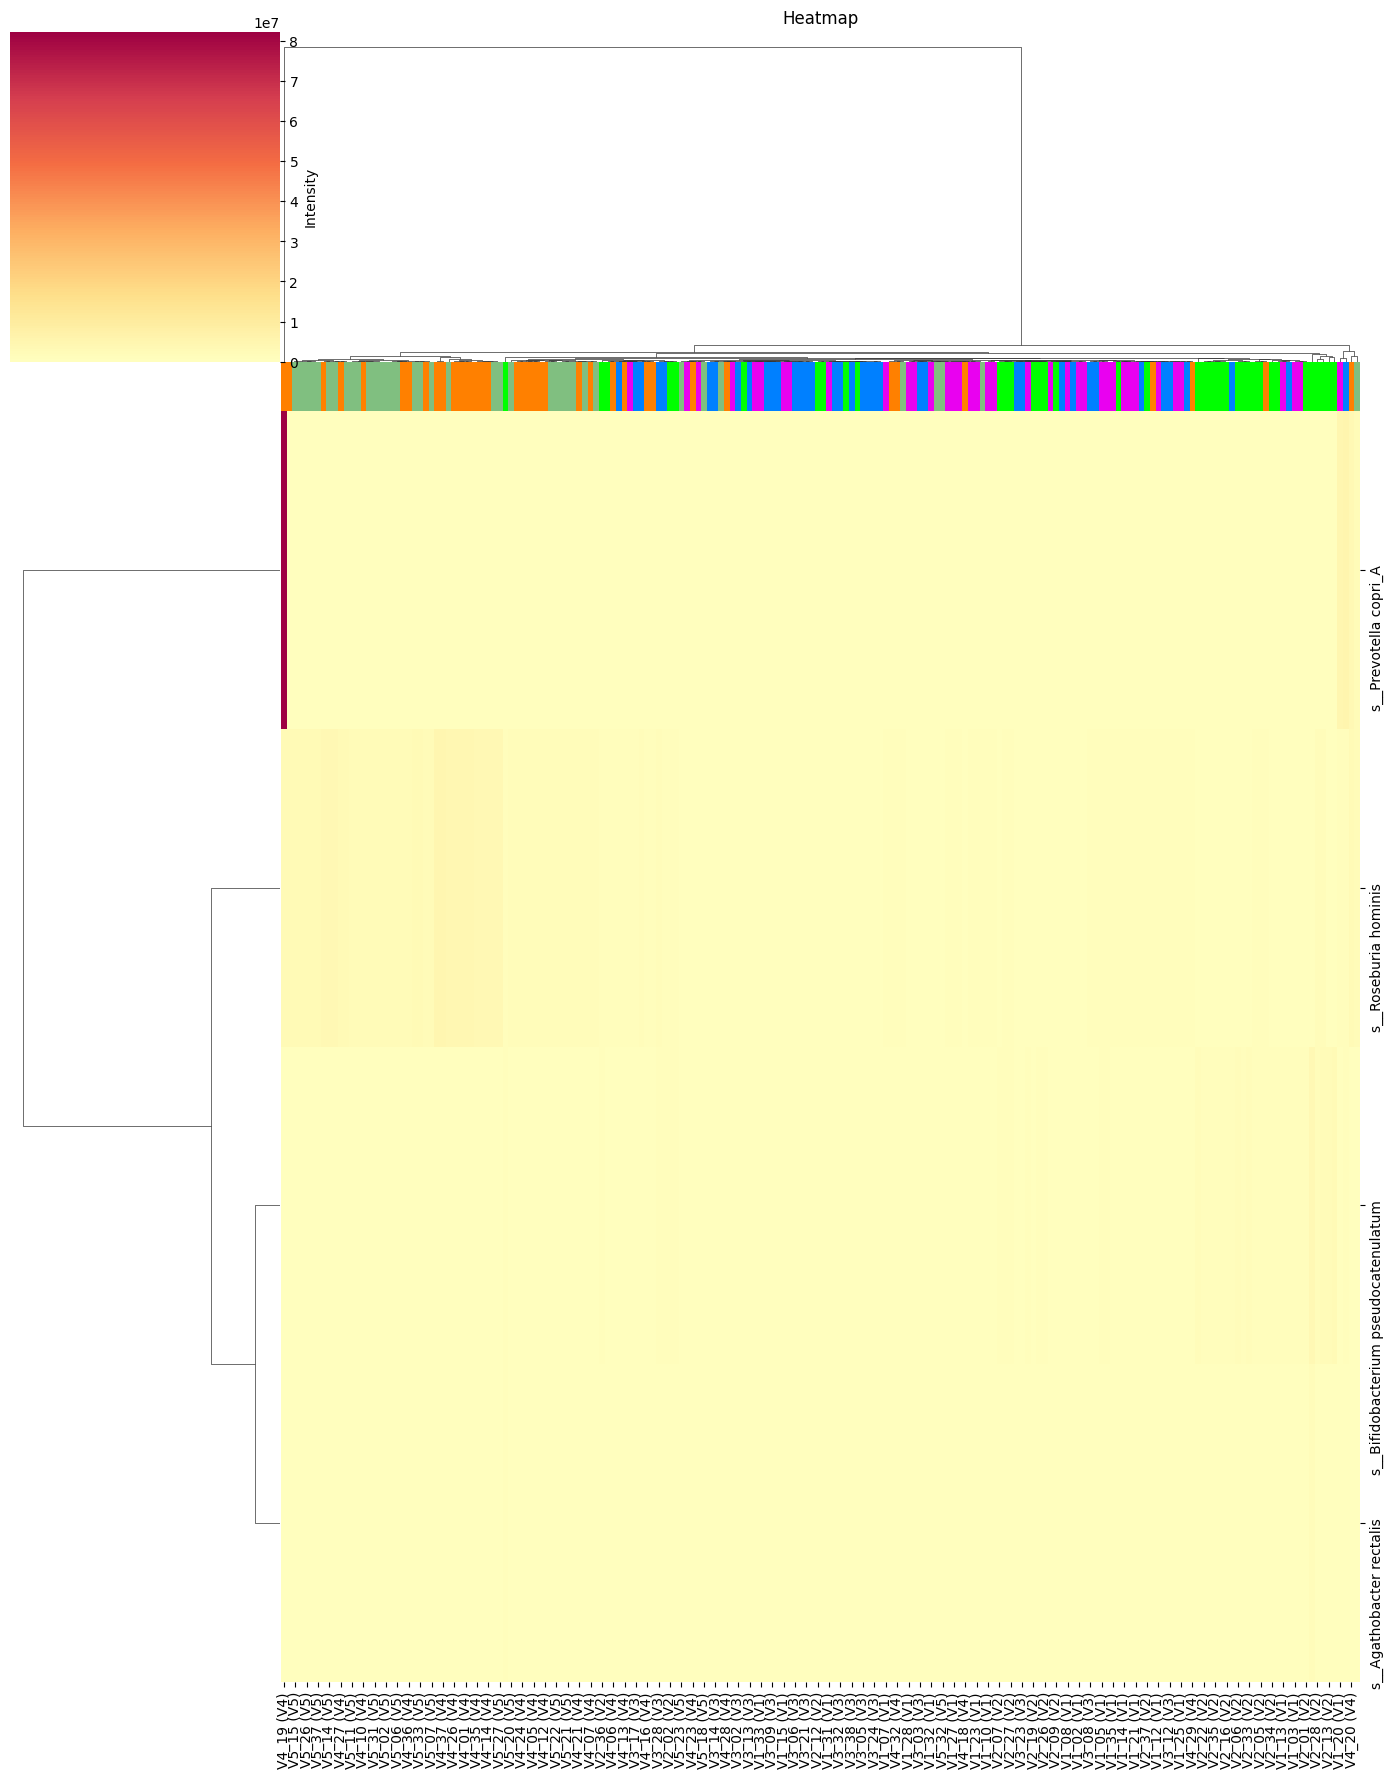

In [47]:

from distinctipy import distinctipy
import seaborn as sns
import matplotlib.pyplot as plt

class HeatmapPlot:
    def __init__(self, tfobj):
        self.tfobj =  tfobj
    # input: df, func_name, top_number, value_type, fig_size
    # EXAMPLE: plot_top_taxa_func_heatmap_of_test_res(df_anova, sw.func, 200, 'f', (30,30))
    def rename_taxa(self, df):
        if df.index.name == 'Taxon':
            index_list = [i.split('|')[-1] for i in df.index.tolist()]
            df.index = index_list
        return df

    def plot_top_taxa_func_heatmap_of_test_res(self, df, top_number:str = 100, 
                                        value_type:str = 'p', fig_size:tuple = None, pvalue:float = 0.05, cmap:str = None, rename_taxa:bool = True):

        
        # if fig_size is None:
        #     width, length, front_title, font_size = self._fit_size(df)
        #     fig_size = (width, length)
        # else:
        #     width, length, front_title, font_size = self._fit_size(df)
        func_name = self.tfobj.func
        dft = df.copy()
        dft.reset_index(inplace=True)
        # dft = dft.iloc[:, :4]
        type_map = {'f': ('f-statistic', 'Spectral_r', 1),
                    'p': ('P-value', 'Reds_r', None),
                    't': ('t-statistic', 'hot_r', 1)}

        if cmap is None:
            plot_type, cmap, scale = type_map.get(value_type, None)
        else:
            plot_type, _, scale = type_map.get(value_type, None)

        if plot_type is None:
            raise ValueError("type must be 'p' or 'f' or 't'")

        
        if plot_type not in df.columns:
            plot_type = 'P-value'


        try:
            dft = dft[dft['P-value'] < pvalue]
            print(f"Number of significant differences between groups in {func_name}-Function: {dft.shape[0]}")
            if dft.empty:
                raise ValueError(f"No significant differences between groups in {func_name}-Function")
            if 'f-statistic' in dft.columns.tolist():
                dft = dft.sort_values(by=['P-value', 'f-statistic'], ascending=[True, False], ignore_index=True)
            elif 't-statistic' in dft.columns.tolist():
                dft = dft.sort_values(by=['P-value', 't-statistic'], ascending=[True, False], ignore_index=True)
            df_top = dft.head(top_number)
            #display(df_top)
            if rename_taxa:
                df_top['Taxon'] = df_top['Taxon'].apply(lambda x: x.split('|')[-1])
            df_top = df_top.pivot(index='Taxon', columns=func_name, values=plot_type)
            display(df_top)
            df_plot = df_top.fillna(1) if plot_type == 'P-value' else df_top.fillna(0)
            

            fig = sns.clustermap(df_plot, center=0, linewidths=.3, linecolor="grey", 
                                figsize=fig_size, cmap = cmap, 
                            method='average',  metric='correlation',cbar_kws={'label': plot_type}, 
                            standard_scale=scale, mask=df_top.isnull(), vmin=0, vmax=1)


            fig.ax_heatmap.set_xlabel('Function')
            fig.ax_heatmap.set_ylabel('Taxa')

            fig.ax_heatmap.set_title(f"Significant differences between groups in Taxa-Function heatmap of {plot_type} (top {top_number})")

            plt.subplots_adjust(left=0.05, bottom=0.4, right=0.5, top=0.95)
            plt.show()
            return fig
        except ValueError as e:
            print(f"Error: {e}")
            plt.close('all')
            raise ValueError(f"No significant differences between groups in {func_name}")
    


    def plot_basic_heatmap_of_test_res(self, df, top_number:int = 100, value_type:str = 'p', 
                                       fig_size:tuple = None, pvalue:float = 0.05, scale = None, 
                                       col_cluster:bool = True, row_cluster:bool = True, cmap:str = None, rename_taxa:bool = True):

        dft = df.copy()

        scale_map ={None: None,
                    'None': None,
                    'row': 0,
                    'column': 1}
        scale = scale_map.get(scale)

        type_map = {'f': ('f-statistic', 'Spectral_r'),
                    'p': ('P-value', 'Reds_r'),
                    't': ('t-statistic', 'hot_r')}

        if cmap is None:
            plot_type, cmap = type_map.get(value_type)
        else:
            plot_type, _ = type_map.get(value_type)

        if plot_type is None:
            raise ValueError("type must be 'p' or 'f' or 't'")

        
        if plot_type not in df.columns:
            plot_type = 'P-value'

        
        dft = dft[dft['P-value'] < pvalue]


        if 'f-statistic' in dft.columns.tolist():
            dft = dft.sort_values(by=['P-value', 'f-statistic'], ascending=[True, False])
            mat = dft.head(top_number)
            mat= mat.drop(['P-value', 'f-statistic' ], axis=1)
        elif 't-statistic' in dft.columns.tolist():
            dft = dft.sort_values(by=['P-value', 't-statistic'], ascending=[True, False])
            mat = dft.head(top_number)
            mat= mat.drop(['P-value', 't-statistic'], axis=1)

        if len(mat) < 2:
            row_cluster = False
        if len(mat.columns) < 2:
            col_cluster = False
            
        meta_df = self.tfobj.meta_df
        meta_name = self.tfobj.meta_name


        if fig_size is None:
            fig_size = (30,30)

        def assign_colors(groups):
            colors = distinctipy.get_colors(len(set(groups)))
            result = []
            for group in groups:
                index = sorted(set(groups)).index(group)
                result.append(colors[index])
            return result
        try:
            # create color list for groups & rename columns
            col_names = mat.columns.tolist()
            groups_list = []
            new_col_names = []
            for i in col_names:
                group = meta_df[meta_df['Sample'] == i]
                group = group[meta_name].values[0]
                new_col_names.append(f'{i} ({group})')
                groups_list.append(group)
            color_list = assign_colors(groups_list)
            mat.columns = new_col_names
            if rename_taxa:
                mat = self.rename_taxa(mat)

            fig  = sns.clustermap(mat, center=0,  cmap = cmap ,figsize=fig_size,
                            cbar_kws={'label': 'Intensity'}, col_cluster=col_cluster, row_cluster=row_cluster,
                                standard_scale=scale, col_colors=color_list)

            fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xmajorticklabels())
            fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_ymajorticklabels())
            fig.ax_col_dendrogram.set_title(f"The Heatmap of intensity sorted by {plot_type} of Significant differences between groups (top {top_number})")

            plt.subplots_adjust(left=0.05, bottom=0.4, right=0.5, top=0.95)
            plt.show()
            return fig
        except Exception as e:
            print(f'Error: {e}')
            plt.close('all')
            raise ValueError("No significant differences")

       

    # Plot basic heatmap of matrix with color bar
    # EXAMPLE: plot_heatmap(sw, mat=get_top_intensity_matrix_of_test_res(df=df_anova, df_type='anova', top_num=100), 
                #  title = 'The heatmap of top 100 significant differences between groups in Taxa-Function', 
                #  fig_size=(30,30), scale=0)
    def plot_basic_heatmap(self,  df, title = 'Heatmap',fig_size:tuple = None, 
                    scale = None, col_cluster:bool = True, row_cluster:bool = True, cmap:str = None, rename_taxa:bool = True):
        if len(df) < 2:
            row_cluster = False
        if len(df.columns) < 2:
            col_cluster = False
        
        scale_map ={None: None,
            'None': None,
            'row': 0,
            'column': 1}
        scale = scale_map.get(scale)

        mat = df.copy()
        meta_df = self.tfobj.meta_df
        meta_name = self.tfobj.meta_name

        # if index is Taxon, rename index
        if rename_taxa:
            mat = self.rename_taxa(mat)

        if cmap is None:
            cmap = 'Spectral_r'
        if fig_size is None:
            fig_size = (30,30)

        def assign_colors(groups):
            colors = distinctipy.get_colors(len(set(groups)))
            result = []
            for group in groups:
                index = sorted(set(groups)).index(group)
                result.append(colors[index])
            return result



        # create color list for groups & rename columns
        col_names = mat.columns.tolist()
        groups_list = []
        new_col_names = []
        for i in col_names:
            group = meta_df[meta_df['Sample'] == i]
            group = group[meta_name].values[0]
            new_col_names.append(f'{i} ({group})')
            groups_list.append(group)
        color_list = assign_colors(groups_list)
        mat.columns = new_col_names

        fig  = sns.clustermap(mat, center=0,  cmap = cmap ,figsize=fig_size,
                        cbar_kws={'label': 'Intensity'}, col_cluster=col_cluster, row_cluster=row_cluster,
                            standard_scale=scale, col_colors=color_list)

        fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xmajorticklabels())
        fig.ax_heatmap.set_yticklabels(fig.ax_heatmap.get_ymajorticklabels())
        fig.ax_col_dendrogram.set_title(title)

        plt.subplots_adjust(left=0.05, bottom=0.4, right=0.5, top=0.95)
        plt.show()
        return fig



    def get_top_across_table(self, df, top_number:str = 100, value_type:str = 'p', pvalue:float = 0.05):
        func_name = self.tfobj.func
        dft = df.copy()
        dft.reset_index(inplace=True)

        if value_type == 'f':
            plot_type = 'f-statistic'
            color = 'Spectral_r'
            scale = 1
        elif value_type == 'p':
            plot_type = 'P-value'
            color = 'Reds_r'
            scale = None
        elif value_type == 't':
            plot_type = 't-statistic'
            color = 'hot_r'
            scale = 1
        else:
            raise ValueError("type must be 'p' or 'f' or 't'")
        if plot_type not in df.columns:
            plot_type = 'P-value'


        try:        
            dft = dft[dft['P-value'] < pvalue]
            if dft.empty:
                raise ValueError(f"No significant differences between groups")
            if 'f-statistic' in dft.columns.tolist():
                dft = dft.sort_values(by=['P-value', 'f-statistic'], ascending=[True, False], ignore_index=True)
            elif 't-statistic' in dft.columns.tolist():
                dft = dft.sort_values(by=['P-value', 't-statistic'], ascending=[True, False], ignore_index=True)
            df_top = dft.head(top_number)
            #display(df_top)
            df_top = df_top.pivot(index='Taxon', columns=func_name, values=plot_type)
            mat = df_top.fillna(1) if plot_type == 'P-value' else df_top.fillna(0)
            plt.figure()
            fig = sns.clustermap(mat, center=0, linewidths=.3, linecolor="grey", cmap = color,
                            method='average',  metric='correlation',cbar_kws={'label': plot_type}, 
                            standard_scale=scale, mask=df_top.isnull(), vmin=0, vmax=1)


            # get the sorted dataframe
            row_num = len(mat)
            col_num = len(mat.columns)
            if row_num > 1 and col_num < 2:
                sorted_df = mat.iloc[fig.dendrogram_row.reordered_ind, :]
            elif row_num < 2 and col_num > 1:
                sorted_df = mat.iloc[:, fig.dendrogram_col.reordered_ind]
            elif row_num > 1 and col_num > 1:
                sorted_df = mat.iloc[fig.dendrogram_row.reordered_ind, fig.dendrogram_col.reordered_ind]
            else:
                sorted_df = mat
            # remove fig object
            # plt.close(fig.fig)
            return sorted_df
        except ValueError as e:
            print(e)
            raise ValueError(f"No significant differences between groups")
        finally:
            plt.close('all')

        


    def get_top_across_table_basic(self, df, top_number:int = 100, value_type:str = 'p', 
                                       fig_size:tuple = None, pvalue:float = 0.05, scale = None, 
                                       col_cluster:bool = True, row_cluster:bool = True, cmap:str = None):
        dft = df.copy()

        scale_map ={None: None,
                    'None': None,
                    'row': 0,
                    'column': 1}
        scale = scale_map.get(scale)

        type_map = {'f': ('f-statistic', 'Spectral_r'),
                    'p': ('P-value', 'Reds_r'),
                    't': ('t-statistic', 'hot_r')}

        if cmap is None:
            plot_type, cmap = type_map.get(value_type)
        else:
            plot_type, _ = type_map.get(value_type)

        if plot_type is None:
            raise ValueError("type must be 'p' or 'f' or 't'")

        
        if plot_type not in df.columns:
            plot_type = 'P-value'

        
        dft = dft[dft['P-value'] < pvalue]


        if 'f-statistic' in dft.columns.tolist():
            dft = dft.sort_values(by=['P-value', 'f-statistic'], ascending=[True, False])
            mat = dft.head(top_number)
            mat= mat.drop(['P-value', 'f-statistic' ], axis=1)
        elif 't-statistic' in dft.columns.tolist():
            dft = dft.sort_values(by=['P-value', 't-statistic'], ascending=[True, False])
            mat = dft.head(top_number)
            mat= mat.drop(['P-value', 't-statistic'], axis=1)

        if len(mat) < 2:
            row_cluster = False
        if len(mat.columns) < 2:
            col_cluster = False
            
        meta_df = self.tfobj.meta_df
        meta_name = self.tfobj.meta_name


        if fig_size is None:
            fig_size = (30,30)

        def assign_colors(groups):
            colors = distinctipy.get_colors(len(set(groups)))
            result = []
            for group in groups:
                index = sorted(set(groups)).index(group)
                result.append(colors[index])
            return result
        try:
            # create color list for groups & rename columns
            col_names = mat.columns.tolist()
            groups_list = []
            new_col_names = []
            for i in col_names:
                group = meta_df[meta_df['Sample'] == i]
                group = group[meta_name].values[0]
                new_col_names.append(f'{i} ({group})')
                groups_list.append(group)
            color_list = assign_colors(groups_list)
            mat.columns = new_col_names

            fig  = sns.clustermap(mat, center=0,  cmap = cmap ,figsize=fig_size,
                            cbar_kws={'label': 'Intensity'}, col_cluster=col_cluster, row_cluster=row_cluster,
                                standard_scale=scale, col_colors=color_list)

            # get the sorted dataframe
            if row_cluster and not col_cluster:
                sorted_df = mat.iloc[fig.dendrogram_row.reordered_ind, :]
            elif col_cluster and not row_cluster:
                sorted_df = mat.iloc[:, fig.dendrogram_col.reordered_ind]
            elif row_cluster and col_cluster:
                sorted_df = mat.iloc[fig.dendrogram_row.reordered_ind, fig.dendrogram_col.reordered_ind]
            else:
                sorted_df = mat

            return sorted_df
        except Exception as e:
            print(f'Error: {e}')
            raise ValueError("No significant differences between groups")
        finally:
            plt.close('all')


# HeatmapPlot(sw).plot_basic_heatmap_of_test_res(df=df_ttest)
# HeatmapPlot(sw).plot_basic_heatmap_of_test_res(df=df_ttest2)
HeatmapPlot(sw).plot_basic_heatmap(df=df, rename_taxa=True)
# HeatmapPlot(sw).plot_basic_heatmap_of_test_res(df=df, top_number=100, value_type='p', fig_size=(30,16), pvalue=0.05, 
#                                                                           scale = "column", col_cluster = True, row_cluster = True, cmap = None)